In [88]:
import pandas as pd
from datapackage import Package
import matplotlib.pyplot as plt
import numpy as np
from iso3166 import countries
import plotly.io as pio
import math
from sklearn.feature_selection import f_classif
from scipy.stats import chi2_contingency

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

# Country Code to Country Mapping

In [35]:
package = Package('https://datahub.io/core/country-list/datapackage.json')

# print list of all resources:
#print(package.resource_names)

# print processed tabular data (if exists any)
for resource in package.resources:
    if resource.descriptor['datahub']['type'] == 'derived/csv':
        content = resource.read()
ISO_Alpha2_Country_Mapping = {item[1]:item[0] for item in content}
ISO_Alpha2_Country_Mapping['KR']='Korea' #From 'Korea, Republic of' to Korea

# How Language affects Trending

In [36]:
DF = pd.read_pickle("../Data/Cleaned_Data(No_Agg).pkl")

In [37]:
DF['Lang'].fillna('Unknown', inplace=True)

In [38]:
DF['Lang'].replace({'English (United Kingdom)':'English', 'Spanish (Latin America)':'Spanish', 'Spanish (Spain)':'Spanish'}, inplace=True)


### Which Language Trended the most in which countries?

In [39]:
Country_Vs_Lang_Table = DF.groupby(['viewing_country', 'Lang'])['video_id'].count().unstack()
Country_Vs_Lang_Table = Country_Vs_Lang_Table.fillna(value=0).astype('int64')

In [40]:
def toppers(x, how_many=3):
    toppers = {key:x.to_dict()[key] for key in sorted(x.to_dict(), key=lambda y: x.to_dict()[y], reverse=True)[:how_many]}
    toppers.update({'Other':x.sum() - sum(toppers.values())})
    return toppers

Outer = Country_Vs_Lang_Table.sum(axis=1)

Inner = Country_Vs_Lang_Table.apply(lambda x:toppers(x,2), axis=1)   

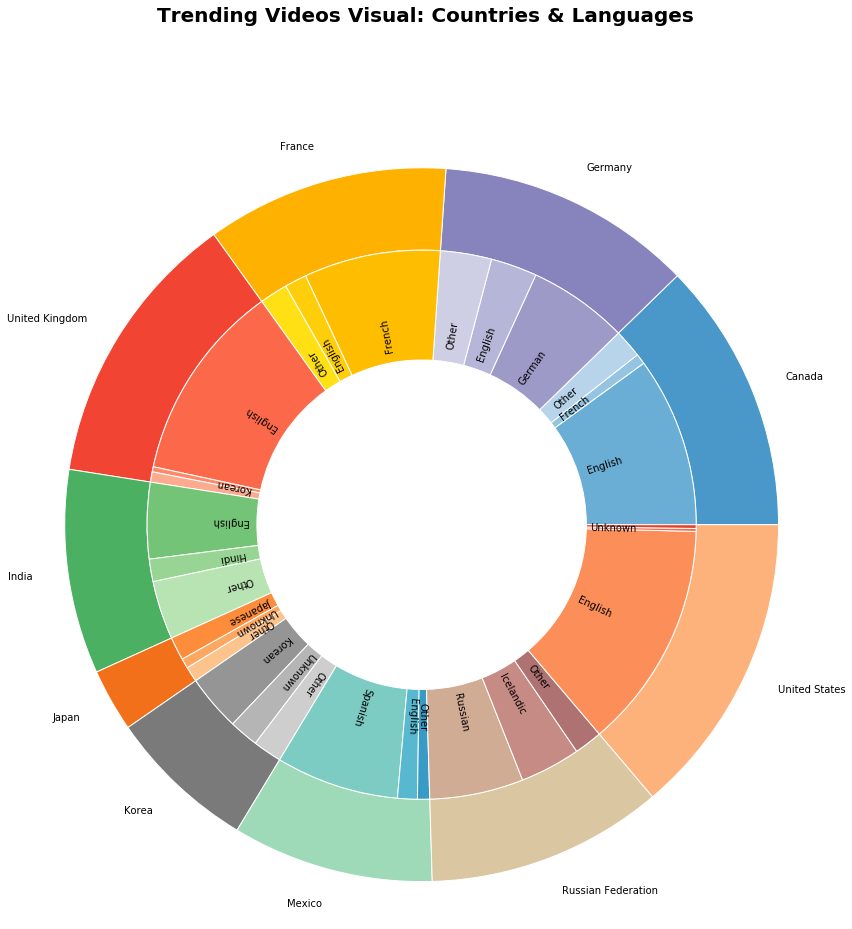

In [41]:
fig, axis = plt.subplots(figsize = (12,12))
_=axis.axis('equal')
color_range = [plt.cm.Blues, plt.cm.Purples, plt.cm.Wistia, plt.cm.Reds, plt.cm.Greens, plt.cm.Oranges , plt.cm.Greys, plt.cm.GnBu_r, plt.cm.pink, plt.cm.OrRd_r]
colors = [color(0.6) for color in color_range]

#Outer pie
labels = [ISO_Alpha2_Country_Mapping[cc] for cc in Outer.index]
pie1= axis.pie(Outer, labels=labels, colors=colors,radius=1.3)  
_=plt.setp(pie1[0], width=0.3, edgecolor='white' )

#Inner pie
names = list(np.array([list(item) for item in Inner.map(lambda x: x.keys()).to_list()]).flatten())
values = list(np.array([list(item) for item in Inner.map(lambda x: x.values()).to_list()]).flatten())
colors = []
for color in color_range:
    colors = colors + [color(i) for i in [0.5,0.4,0.3]]
pie2 = axis.pie(values, radius=1.3-0.3, labels=names, labeldistance=0.7, colors=colors)
_=plt.setp(pie2[0], width=0.4, edgecolor='white')
_=plt.margins(0,0)

# do the rotation of the labels
for w, t in zip(pie2[0], pie2[1]):
    mang =(w.theta1 + w.theta2)/2.  # get mean_angle of the wedge
    #print(mang, t.get_rotation())
    _=t.set_rotation(mang)         # rotate the label by (mean_angle + 270)
    _=t.set_va("center")
    _=t.set_ha("center")
    _=t.set
#Tiding up the clutter
_=pie2[1][11].set_visible(False)
_=pie2[1][-1].set_visible(False)
_=axis.axis('equal')

_=plt.suptitle('Trending Videos Visual: Countries & Languages', fontsize=20, weight='bold', y=1.1)

_=plt.tight_layout()
_= plt.savefig('../Image/Lang1.png', bbox_inches = "tight" )
_=plt.show()


**As we would expect, The local language seems to play a big role in trending**

# Is there any difference in popularity for trending (longevity) across countries ?

In [42]:
DF = pd.read_pickle('../Data/Popularity_DF.pkl')

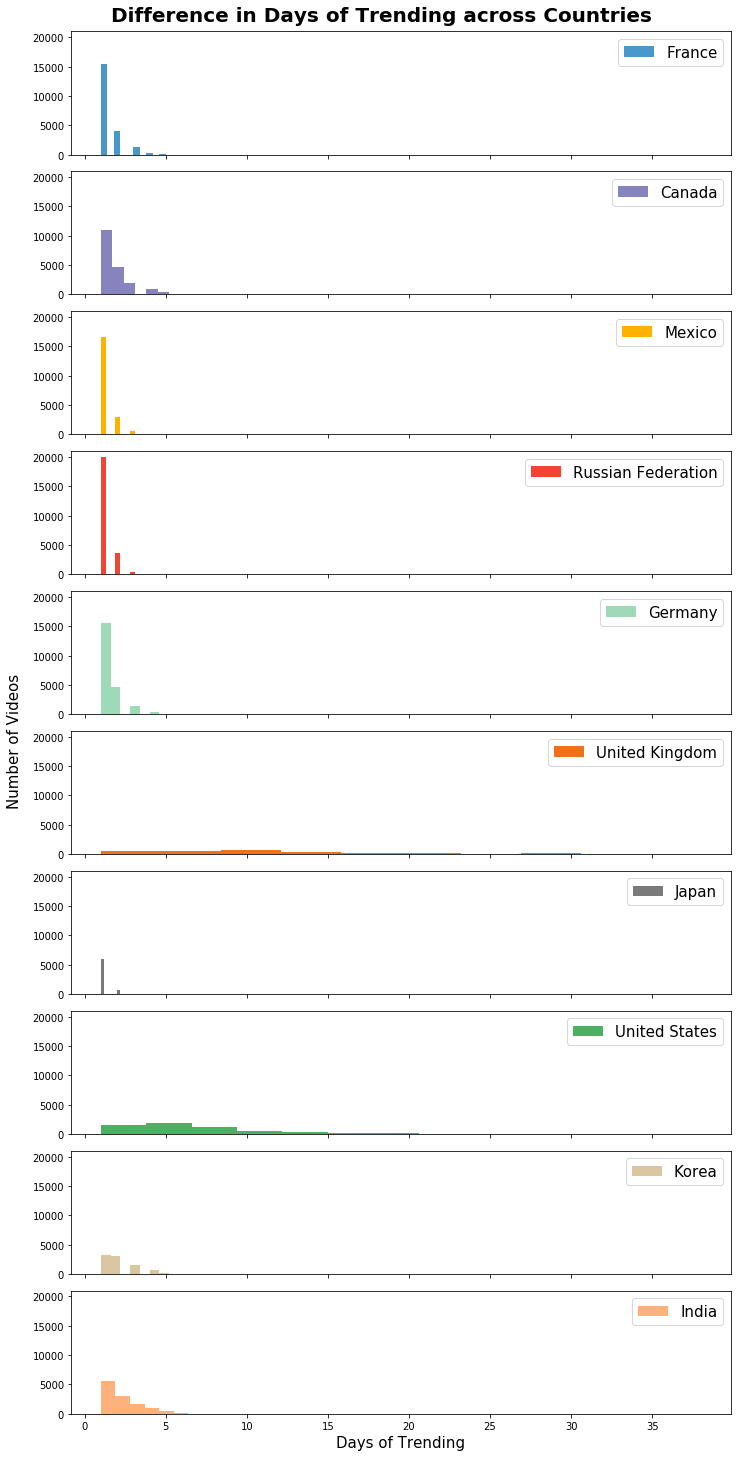

In [43]:
List_of_CCs = DF['viewing_country'].unique()

fig, axs = plt.subplots(10, 1, sharex=True, sharey=True, tight_layout=True, figsize=(10,20))

color_range = [plt.cm.Blues, plt.cm.Purples, plt.cm.Wistia, plt.cm.Reds, plt.cm.GnBu_r, plt.cm.Oranges , plt.cm.Greys, plt.cm.Greens , plt.cm.pink, plt.cm.OrRd_r]
colors = [color(0.6) for color in color_range]

for index,cc in enumerate(List_of_CCs):
    _=axs[index].hist(DF[DF['viewing_country']==cc]['Total_Trend_Days'], color=colors[index], alpha=1, label=ISO_Alpha2_Country_Mapping[cc])

    #legend
    _=axs[index].legend(loc='upper right', fontsize = 15)
    

    
_=plt.suptitle('Difference in Days of Trending across Countries', fontsize=20, weight='bold', y=1.01) 
#xlabel, ylabel
_=plt.xlabel('Days of Trending',fontsize = 15)
_=fig.text(-0.02, 0.5, 'Number of Videos', va='center', rotation='vertical', fontsize = 15)


_ = plt.tight_layout()
_= plt.savefig('../Image/Popularity_Across_Countries.png', bbox_inches = "tight" )
plt.show()

# Is there any difference in popularity for trending (longevity) across countries ?

In [44]:
DF = pd.read_pickle('../Data/Popularity_DF.pkl')

In [45]:
DF['Language'].fillna('Unknown', inplace=True)
DF['Language'].replace({'English (United Kingdom)':'English', 'Spanish (Latin America)':'Spanish', 'Spanish (Spain)':'Spanish'}, inplace=True)


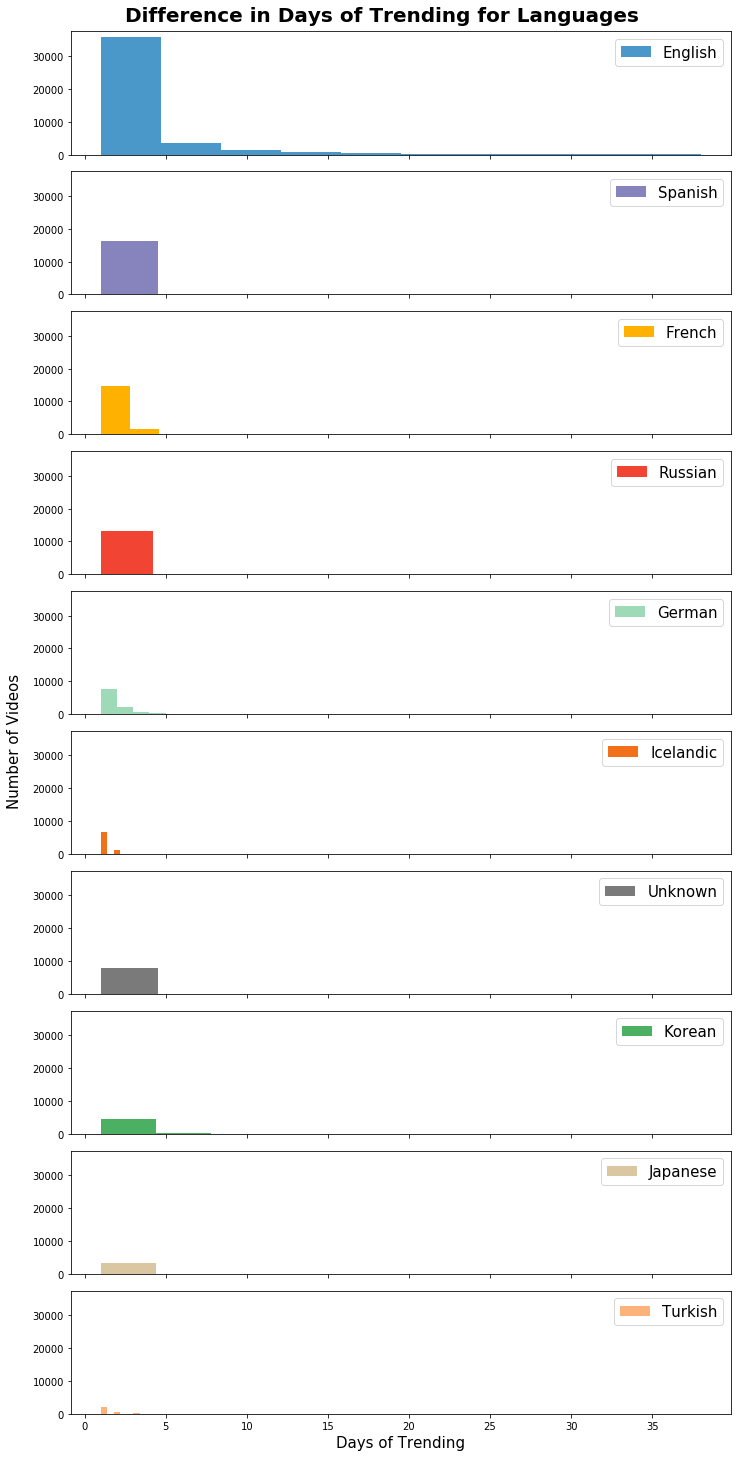

In [46]:
Top10 = DF['Language'].value_counts().index[:10]

fig, axs = plt.subplots(10, 1, sharex=True, sharey=True, tight_layout=True, figsize=(10,20))

color_range = [plt.cm.Blues, plt.cm.Purples, plt.cm.Wistia, plt.cm.Reds, plt.cm.GnBu_r, plt.cm.Oranges , plt.cm.Greys, plt.cm.Greens , plt.cm.pink, plt.cm.OrRd_r]
colors = [color(0.6) for color in color_range]

for index,lang in enumerate(Top10):
    _=axs[index].hist(DF[DF['Language']==lang]['Total_Trend_Days'], color=colors[index], alpha=1, label=lang)

    #legend
    _=axs[index].legend(loc='upper right', fontsize = 15)
    

    
_=plt.suptitle('Difference in Days of Trending for Languages', fontsize=20, weight='bold', y=1.01) 
#xlabel, ylabel
_=plt.xlabel('Days of Trending',fontsize = 15)
_=fig.text(-0.02, 0.5, 'Number of Videos', va='center', rotation='vertical', fontsize = 15)


_ = plt.tight_layout()
_= plt.savefig('../Image/Popularity_for_Languages.png', bbox_inches = "tight" )
plt.show()

# How similar countries are in terms of their taste in trending videos ?

In [47]:
DF = pd.read_pickle('../Data/Popularity_DF.pkl')

In [48]:
Country_Video_Table = DF.groupby('viewing_country').aggregate(Video_List = ('video_id', lambda x: x.to_list()))


In [49]:
Country_Video_Table.index = [ISO_Alpha2_Country_Mapping[cc] for cc in Country_Video_Table.index]
Country_Video_Table

,Video_List
Canada,"[--45ws7CEN0, --7vNbh4UNA, --YgtVuvWGo, --wOJ2..."
Germany,"[--7vNbh4UNA, --I0aj8MUdU, --moh3hSPpY, --rE6D..."
France,"[--2K8l6BWfw, --728h8mnDY, --8-sr76Haw, --DqT_..."
United Kingdom,"[--uXQQ0h-yQ, -3VBPAZPTQI, -43MBOJnVks, -5WBCr..."
India,"[-0WuM6ctLHg, -0mcgX4ro7I, -0qWaHPYLRc, -0rIUy..."
Japan,"[-09XygZcXEU, -0Gd9DBh3W4, -0q2P8spwng, -1Uptv..."
Korea,"[-0SxwCD7Uc4, -0YMxuZ8ezo, -0exy3EqrvQ, -0i1pb..."
Mexico,"[--45ws7CEN0, -0EPhTUesFo, -0XyhJkpXjM, -0vcE2..."
Russian Federation,"[--45ws7CEN0, --9LvCHDHYQ, -07PqRbugOM, -0Zl7W..."
United States,"[-0CMnp02rNY, -0NYY8cqdiQ, -1Hm41N0dUs, -1yT-K..."


In [50]:
def Cosine_Similarity_Matrix(Table):
    N = Table.index.to_list()
    Sim_Matrix = pd.DataFrame(index=N, columns=N)
    for row in N:
        for col in N:
            Num = len(set(Table.loc[row][0]).intersection(set(Table.loc[col][0])))
            Denom = np.sqrt(len(Table.loc[row][0])*len(Table.loc[col][0]))
            Sim_Matrix.loc[row,col] = Num/Denom
    Sim_Matrix = Sim_Matrix.astype('float') 
    return Sim_Matrix

def Jaccard_Similarity_Matrix(Table):
    N = Table.index.to_list()
    Sim_Matrix = pd.DataFrame(index=N, columns=N)
    for row in N:
        for col in N:
            Num = len(set(Table.loc[row][0]).intersection(set(Table.loc[col][0])))
            Denom = len(set(Table.loc[row][0]).union(set(Table.loc[col][0])))
            Sim_Matrix.loc[row,col] = Num/Denom
    Sim_Matrix = Sim_Matrix.astype('float') 
    return Sim_Matrix
    

,Canada,Germany,France,United Kingdom,India,Japan,Korea,Mexico,Russian Federation,United States
Canada,1.000000,0.206175,0.161927,0.113342,0.082421,0.036209,0.034402,0.064335,0.022374,0.195455
Germany,0.206175,1.000000,0.140922,0.059018,0.043016,0.026018,0.020276,0.054633,0.069039,0.088373
France,0.161927,0.140922,1.000000,0.049524,0.048191,0.024726,0.018591,0.047829,0.033955,0.051685
United Kingdom,0.113342,0.059018,0.049524,1.000000,0.015346,0.019136,0.026448,0.047534,0.020298,0.225973
India,0.082421,0.043016,0.048191,0.015346,1.000000,0.013804,0.007833,0.020530,0.006267,0.025361
Japan,0.036209,0.026018,0.024726,0.019136,0.013804,1.000000,0.043578,0.019242,0.009711,0.019795
Korea,0.034402,0.020276,0.018591,0.026448,0.007833,0.043578,1.000000,0.014603,0.008298,0.019608
Mexico,0.064335,0.054633,0.047829,0.047534,0.020530,0.019242,0.014603,1.000000,0.015194,0.047924
Russian Federation,0.022374,0.069039,0.033955,0.020298,0.006267,0.009711,0.008298,0.015194,1.000000,0.015232
United States,0.195455,0.088373,0.051685,0.225973,0.025361,0.019795,0.019608,0.047924,0.015232,1.000000


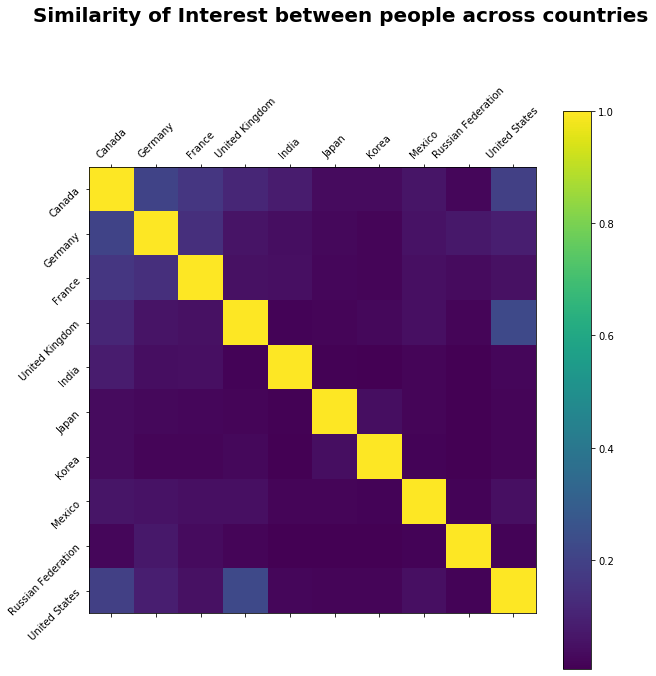

In [52]:
Similarity = Cosine_Similarity_Matrix(Country_Video_Table)
Similarity

_=plt.figure(figsize=(10,10))
_=plt.matshow(Similarity, fignum=1)
_=plt.xticks(range(len(Similarity.columns)), Similarity.columns, rotation=45)
_=plt.yticks(range(len(Similarity.columns)), Similarity.columns, rotation=45)
_=plt.colorbar()
_=plt.suptitle('Similarity of Interest between people across countries', fontsize=20, weight='bold', y=1.01) 
_= plt.savefig('../Image/Correlation_on_video_watch.png')
_=plt.show()

,Canada,Germany,France,United Kingdom,India,Japan,Korea,Mexico,Russian Federation,United States
Canada,1.000000,0.114609,0.087956,0.039203,0.041839,0.016171,0.016253,0.033224,0.011238,0.089151
Germany,0.114609,1.000000,0.075790,0.018954,0.021008,0.011153,0.009246,0.028056,0.035718,0.036837
France,0.087956,0.075790,1.000000,0.016075,0.023714,0.010691,0.008534,0.024491,0.017238,0.021443
United Kingdom,0.039203,0.018954,0.016075,1.000000,0.006015,0.008767,0.011413,0.015743,0.006220,0.119013
India,0.041839,0.021008,0.023714,0.006015,1.000000,0.006665,0.003883,0.010038,0.002966,0.011937
Japan,0.016171,0.011153,0.010691,0.008767,0.006665,1.000000,0.022075,0.008415,0.004036,0.009952
Korea,0.016253,0.009246,0.008534,0.011413,0.003883,0.022075,1.000000,0.006764,0.003691,0.009649
Mexico,0.033224,0.028056,0.024491,0.015743,0.010038,0.008415,0.006764,1.000000,0.007626,0.020166
Russian Federation,0.011238,0.035718,0.017238,0.006220,0.002966,0.004036,0.003691,0.007626,1.000000,0.005999
United States,0.089151,0.036837,0.021443,0.119013,0.011937,0.009952,0.009649,0.020166,0.005999,1.000000


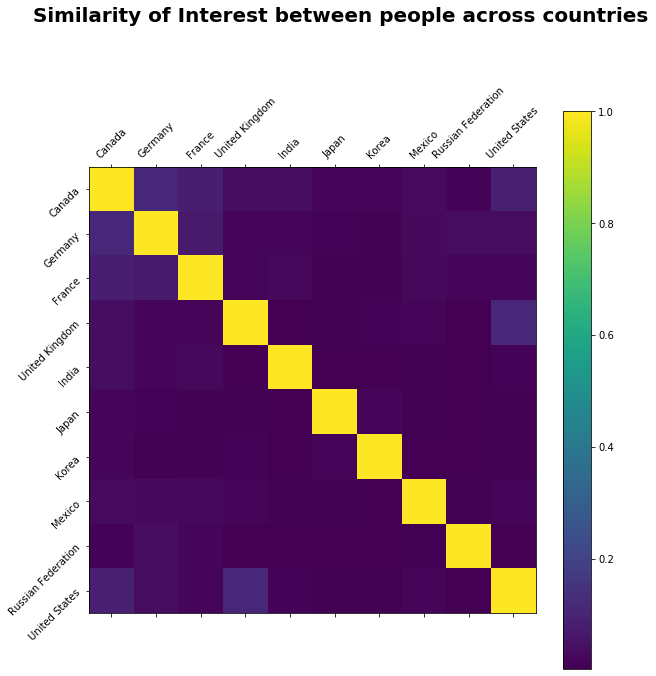

In [53]:
Similarity2 = Jaccard_Similarity_Matrix(Country_Video_Table)
Similarity2

_=plt.figure(figsize=(10,10))
_=plt.matshow(Similarity2, fignum=1)
_=plt.xticks(range(len(Similarity2.columns)), Similarity.columns, rotation=45)
_=plt.yticks(range(len(Similarity2.columns)), Similarity.columns, rotation=45)
_=plt.colorbar()
_=plt.suptitle('Similarity of Interest between people across countries', fontsize=20, weight='bold', y=1.01) 
_= plt.savefig('../Image/Correlation_on_video_watch.png')
_=plt.show()

In [54]:
Country_ISO_Dict = {val:key for key,val in ISO_Alpha2_Country_Mapping.items()}
Country_similarity = dict()
for i,j in zip(*np.where(Similarity>=0.1)):
    if (i!=j):
        Country_similarity[Country_ISO_Dict[Similarity.index[i]]]=Country_similarity.get(Country_ISO_Dict[Similarity.index[i]], [])+[Country_ISO_Dict[Similarity.index[j]]]
        
Country_similarity #Will be used later for censorship analysis 

{'CA': ['DE', 'FR', 'GB', 'US'],
 'DE': ['CA', 'FR'],
 'FR': ['CA', 'DE'],
 'GB': ['CA', 'US'],
 'US': ['CA', 'GB']}

In [55]:
Sorted_Similarity = Similarity.stack().sort_values(ascending=False)

In [56]:
Morethan10perc = Sorted_Similarity[Sorted_Similarity!=1][Sorted_Similarity[Sorted_Similarity!=1]>=0.1].reset_index()

In [57]:
Morethan10perc.reset_index(inplace=True)
Morethan10perc.columns = ['index', 'countries', 'relationship', 'similarity']

In [58]:
Morethan10perc['relationship'] = Morethan10perc.apply(lambda x: "Relationship: {}".format(x['index']//2 + 1), axis=1)

In [59]:
Morethan10perc['iso_code'] = Morethan10perc['countries'].map(Country_ISO_Dict)
Morethan10perc['iso_code_alpha3'] = Morethan10perc['iso_code'].map(lambda x: [item for item in countries.get(x)][2])
Country_RelationShip_Dict = Morethan10perc.groupby('countries').aggregate(relationships =  ('relationship', lambda x: '\n'.join(x.to_list()))).to_dict()['relationships']   
Morethan10perc['relationships'] = Morethan10perc['countries'].map(lambda x: "{}: {}".format(x, Country_RelationShip_Dict[x]))


In [60]:
import plotly.express as px

fig = px.line_geo(Morethan10perc, hover_name= 'relationships',locations="iso_code_alpha3",
                  color="relationship",
                  projection="equirectangular")

pio.write_html(fig, file='../Image/Conuntry_Similarity_based_on_what_is_trending.html', auto_open=True)
#'equirectangular', 'orthographic'

fig.show()

# What categories are liked in which coutries? Is there a similarity?

In [61]:
DF = pd.read_pickle("../Data/Cleaned_Data(No_Agg).pkl")

In [62]:
Country_Vs_Cat_Table = DF.groupby(['viewing_country', 'category'])['video_id'].count().unstack()
Country_Vs_Cat_Table = Country_Vs_Cat_Table.fillna(value=0).astype('int64')

In [63]:
def toppers(x, how_many=3):
    toppers = {key:x.to_dict()[key] for key in sorted(x.to_dict(), key=lambda y: x.to_dict()[y], reverse=True)[:how_many]}
    toppers.update({'Other':x.sum() - sum(toppers.values())})
    return toppers

Outer = Country_Vs_Cat_Table.sum(axis=1)

Inner = Country_Vs_Cat_Table.apply(lambda x:toppers(x,4), axis=1)   

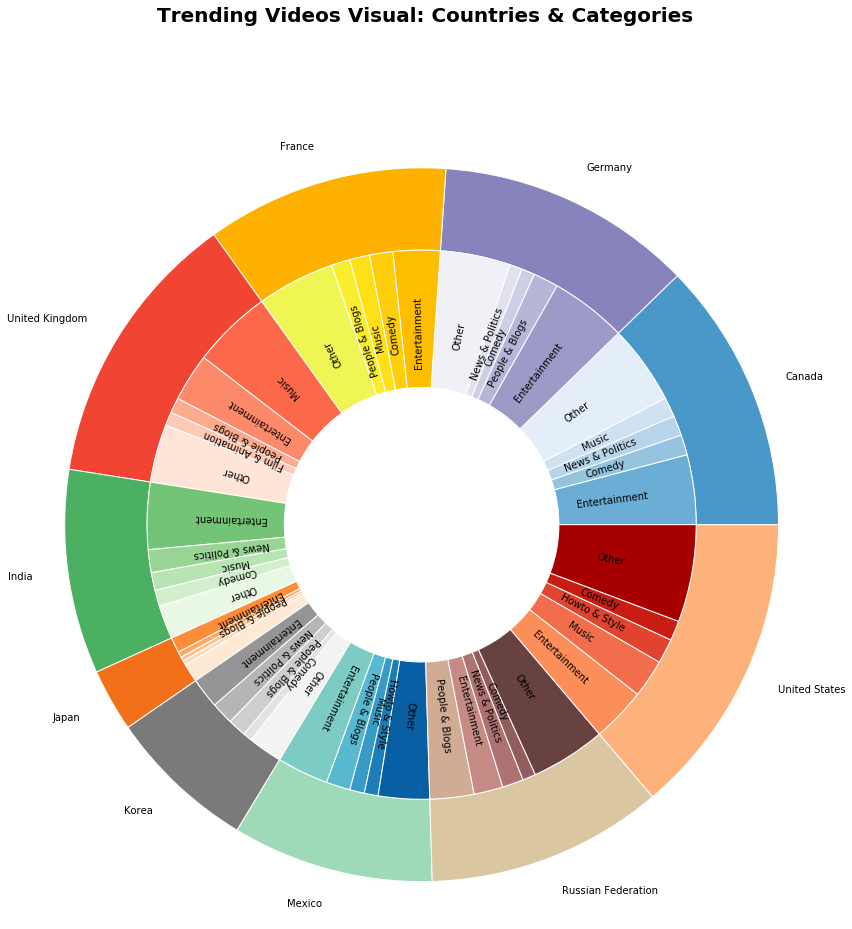

In [64]:
fig, axis = plt.subplots(figsize = (12,12))
_=axis.axis('equal')
color_range = [plt.cm.Blues, plt.cm.Purples, plt.cm.Wistia, plt.cm.Reds, plt.cm.Greens, plt.cm.Oranges , plt.cm.Greys, plt.cm.GnBu_r, plt.cm.pink, plt.cm.OrRd_r]
colors = [color(0.6) for color in color_range]

#Outer pie
labels = [ISO_Alpha2_Country_Mapping[cc] for cc in Outer.index]
pie1= axis.pie(Outer, labels=labels, colors=colors,radius=1.3)  
_=plt.setp(pie1[0], width=0.3, edgecolor='white' )

#Inner pie
names = list(np.array([list(item) for item in Inner.map(lambda x: x.keys()).to_list()]).flatten())
values = list(np.array([list(item) for item in Inner.map(lambda x: x.values()).to_list()]).flatten())
colors = []
for color in color_range:
    colors = colors + [color(i) for i in [0.5,0.4,0.3,0.2,0.1]]
pie2 = axis.pie(values, radius=1.3-0.3, labels=names, labeldistance=0.7, colors=colors)
_=plt.setp(pie2[0], width=0.5, edgecolor='white')
_=plt.margins(0,0)

# do the rotation of the labels
for w, t in zip(pie2[0], pie2[1]):
    mang =(w.theta1 + w.theta2)/2.  # get mean_angle of the wedge
    #print(mang, t.get_rotation())
    _=t.set_rotation(mang)         # rotate the label by (mean_angle + 270)
    _=t.set_va("center")
    _=t.set_ha("center")
    _=t.set
#Tiding up the clutter
_=pie2[1][27].set_visible(False)
_=pie2[1][28].set_visible(False)
_=pie2[1][29].set_visible(False)

_=axis.axis('equal')

_=plt.suptitle('Trending Videos Visual: Countries & Categories', fontsize=20, weight='bold', y=1.1)

_=plt.tight_layout()
_= plt.savefig('../Image/Cat1.png', bbox_inches = "tight" )
_=plt.show()

# Clustering of Countries based on the categories

In [65]:
from sklearn.preprocessing import normalize
#It normalize each sample
scaled_country = normalize(Country_Vs_Cat_Table)
scaled_country = pd.DataFrame(scaled_country, columns=Country_Vs_Cat_Table.columns, index=Country_Vs_Cat_Table.index)

array([2, 2, 1, 3, 2, 2, 0, 2, 0, 1])

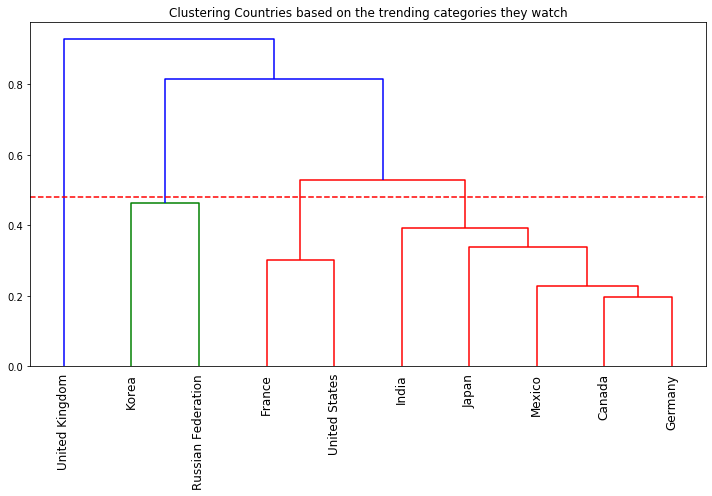

In [66]:
import scipy.cluster.hierarchy as shc
_=plt.figure(figsize=(10, 7))  
_=plt.title("Clustering Countries based on the trending categories they watch")  
dend = shc.dendrogram(shc.linkage(scaled_country, method='ward'))
_=plt.axhline(y=0.48, color='r', linestyle='--')
_=plt.xticks(plt.xticks()[0], [ISO_Alpha2_Country_Mapping[scaled_country.index[id]] for id in dend['leaves']], rotation=90)

from sklearn.cluster import AgglomerativeClustering
cluster = AgglomerativeClustering(n_clusters=4, affinity='euclidean', linkage='ward')  
cluster.fit_predict(scaled_country)

_=plt.tight_layout()
_= plt.savefig('../Image/Country_cluster_based_on_categories.png', bbox_inches = "tight" )
_=plt.show()

In [67]:
Country_Cluster = pd.DataFrame(Country_Vs_Cat_Table.reset_index()['viewing_country'])
Country_Cluster['Country'] = Country_Cluster['viewing_country'].map(ISO_Alpha2_Country_Mapping)
Country_Cluster['iso_code_alpha3'] = Country_Cluster['viewing_country'].map(lambda x: [item for item in countries.get(x)][2])

Country_Cluster['Cluster'] = cluster.fit_predict(scaled_country)


In [68]:
import plotly.express as px

fig = px.choropleth(Country_Cluster, locations="iso_code_alpha3",
                    color="Cluster",
                    hover_name="Country", # column to add to hover information
                    color_continuous_scale=px.colors.sequential.Plasma)
fig.show()

pio.write_html(fig, file='../Image/Country_Clusters_based_on_what_categories_are_trending.html', auto_open=True)

# Is there any difference in popularity (longevity) across categories ?

In [69]:
DF = pd.read_pickle('../Data/Popularity_DF.pkl')

DF['Language'].fillna('Unknown', inplace=True)
DF['Language'].replace({'English (United Kingdom)':'English', 'Spanish (Latin America)':'Spanish', 'Spanish (Spain)':'Spanish'}, inplace=True)


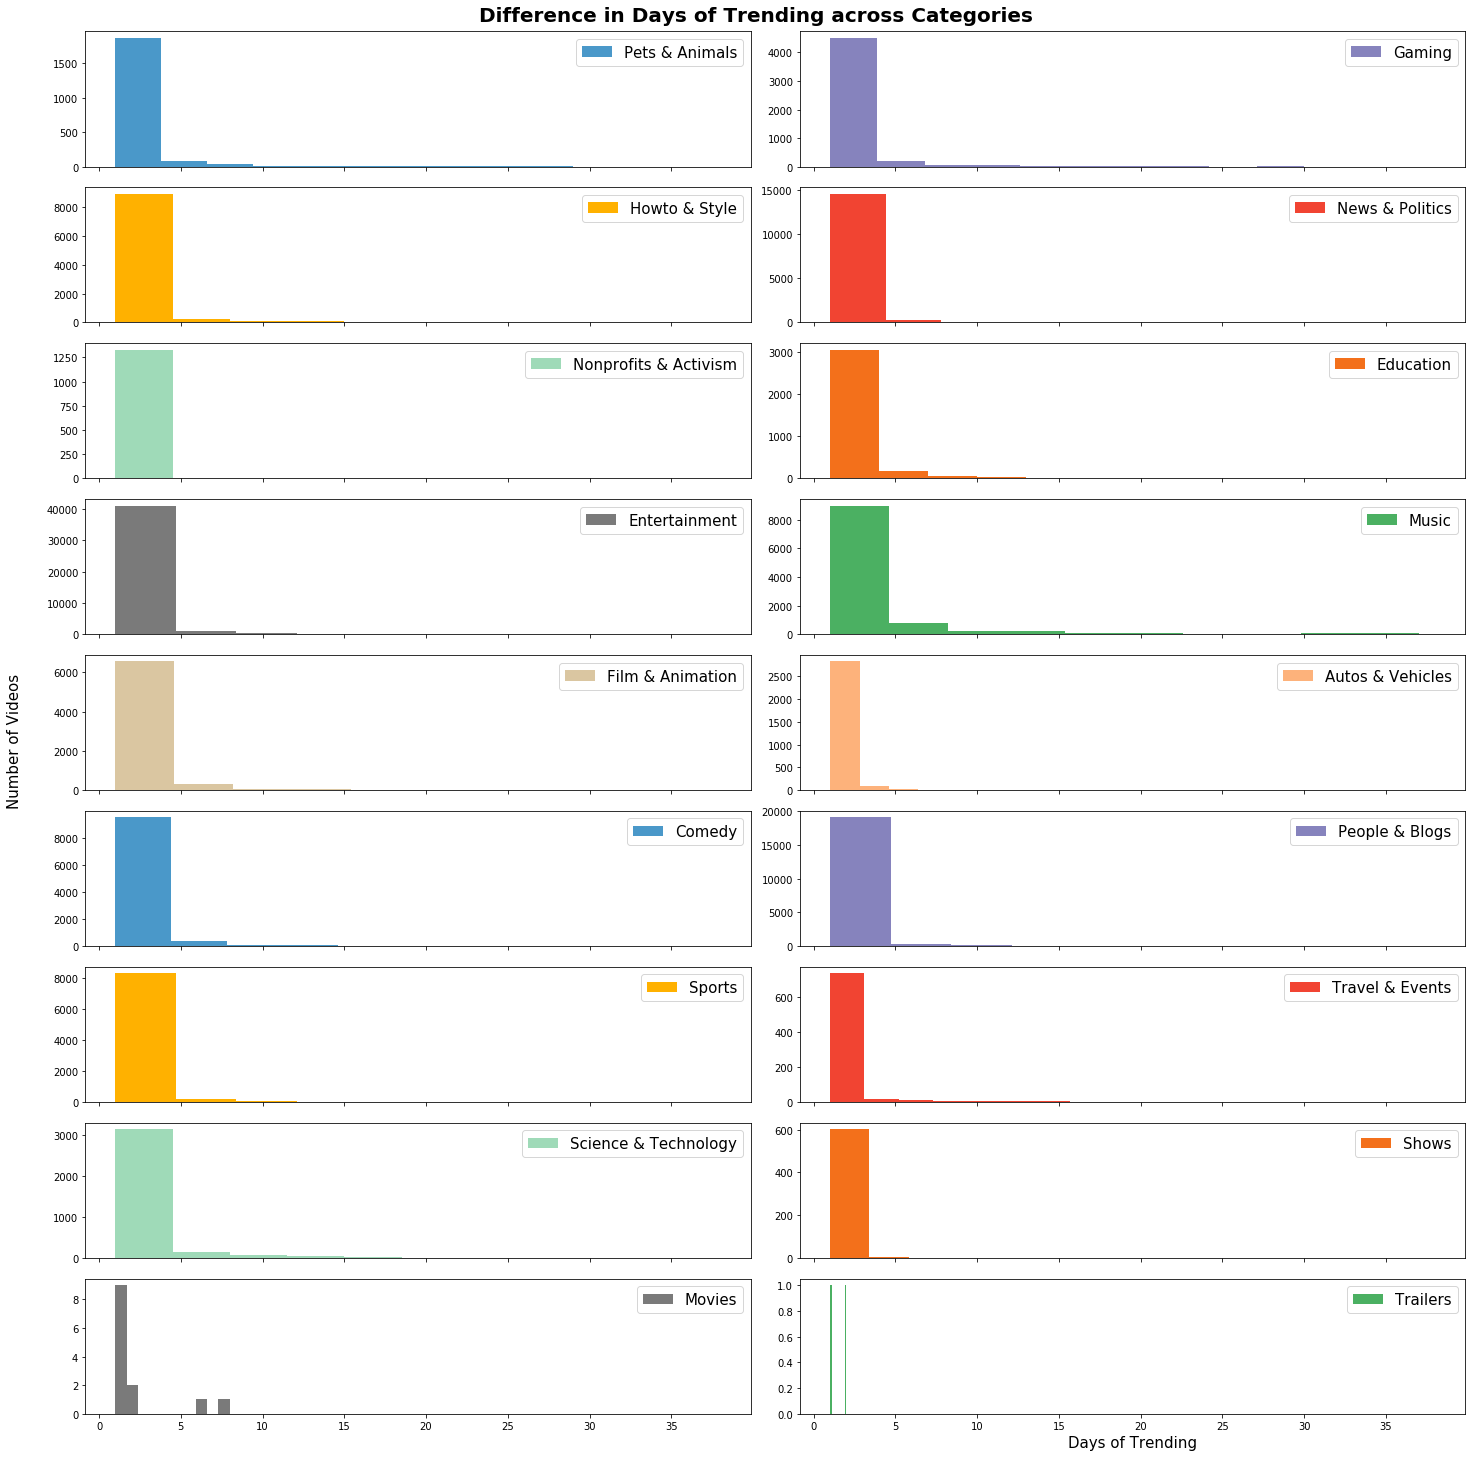

In [70]:
List_of_Cats = DF['Category'].unique()

fig, axs = plt.subplots(9, 2, sharex=True, sharey=False, tight_layout=True, figsize=(20,20))
axs = axs.ravel()
color_range = [plt.cm.Blues, plt.cm.Purples, plt.cm.Wistia, plt.cm.Reds, plt.cm.GnBu_r, plt.cm.Oranges , plt.cm.Greys, plt.cm.Greens , plt.cm.pink, plt.cm.OrRd_r]
colors = [color(0.6) for color in color_range]

for index,cat in enumerate(List_of_Cats):
    _=axs[index].hist(DF[DF['Category']==cat]['Total_Trend_Days'], color=colors[index%10], alpha=1, label=cat)

    #legend
    _=axs[index].legend(loc='upper right', fontsize = 15)
    

    
_=plt.suptitle('Difference in Days of Trending across Categories', fontsize=20, weight='bold', y=1.01) 
#xlabel, ylabel
_=plt.xlabel('Days of Trending',fontsize = 15)
_=fig.text(-0.02, 0.5, 'Number of Videos', va='center', rotation='vertical', fontsize = 15)


_ = plt.tight_layout()
_= plt.savefig('../Image/Popularity_Across_Categories.png', bbox_inches = "tight" )
plt.show()

# Feature Selection of Categorical Variables (Base Version)

## Chi-Squared Feature Selection function

In [80]:
from sklearn.feature_selection import SelectKBest
from sklearn.preprocessing import OrdinalEncoder
from sklearn.feature_selection import chi2
from sklearn.feature_selection import f_classif

# prepare input data
def encode(X):
    oe = OrdinalEncoder()
    oe.fit(X) 
    return oe


def feature_selection(DF, function, ravel=False):
    
    columns = DF.columns
    #Create separate encoders for input and output
    encoder_X = encode(DF[columns[:-1]])
    X = encoder_X.transform(DF[columns[:-1]])

    encoder_Y = encode(DF['Popularity_Category'].to_numpy().reshape(-1,1))
    Y = encoder_Y.transform(DF['Popularity_Category'].to_numpy().reshape(-1,1))
    if ravel:
        Y=Y.ravel()
    fs = SelectKBest(score_func=function, k='all')
    fs.fit(X, Y)
    
    # what are scores for the features
    for i in range(len(fs.scores_)):
        print('Feature %d: %f' % (i, fs.scores_[i]))
    # plot the scores
    _=plt.bar([i for i in range(len(fs.scores_))], fs.scores_)
    _=plt.xticks([i for i in range(len(fs.scores_))], columns[:-1], rotation=90)
    plt.show()
    
    return fs.scores_


In [81]:
def Basic_Cleanup():
    DF = pd.read_pickle('../Data/Popularity_DF.pkl')

    #Language fill NaN and cleanup
    DF['Language'].fillna('Unknown', inplace=True)
    DF['Language'].replace({'English (United Kingdom)':'English', 'Spanish (Latin America)':'Spanish', 'Spanish (Spain)':'Spanish'}, inplace=True)

    Country_Category_Popularity_DF = DF[['viewing_country', 'Category', 'Origin_Country', 'Language', 'Comments_Disabled', 'Ratings_Disabled', 'Blocked', 'Allowed', 'GoogleAnalyticsUsed', 'IsmoderatingComments', 'Total_Trend_Days']].copy()

    #import missingno as msno
    #_=msno.matrix(Country_Category_Popularity_DF)
    #Origin_Country fill NaN and cleanup
    Country_Category_Popularity_DF['Origin_Country'].fillna(value='Not_Disclosed', inplace=True)
    return Country_Category_Popularity_DF


def map_to_cat(x):
    #np.quantile(Country_Category_Popularity_DF['Total_Trend_Days'], [0.95, 0.999])
    #1 -> 'JustTrending'
    #(1 to 5] -> 'Popular' #5 is 95th %
    #(5 to 14] -> 'UlraPopular' #14 is 99.1%
    #>14 -> 'Phenomenon'
    return ('JustTrending' if x==1 else ('Popular' if x<=5 else ('UltraPopular' if x<=14 else "Phenomenon")))

Feature 0: 9126.277171
Feature 1: 1761.372623
Feature 2: 26318.378385
Feature 3: 49291.184215
Feature 4: 126.397132
Feature 5: 91.393941
Feature 6: 133.263739
Feature 7: 72.967471
Feature 8: 121.884385


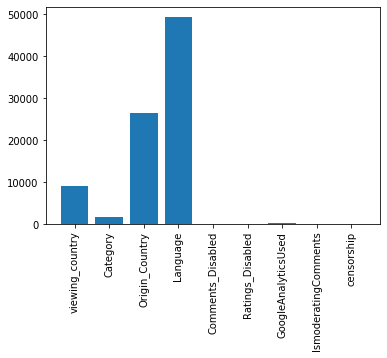

array([ 9126.27717054,  1761.37262298, 26318.37838469, 49291.1842153 ,
         126.39713189,    91.39394086,   133.26373925,    72.96747123,
         121.88438473])

In [82]:
#Retrieve Country_Category_Popularity_DF after basic cleanup
Country_Category_Popularity_DF = Basic_Cleanup()
#Derive a new variable censorship if any blocking
Country_Category_Popularity_DF['censorship'] = Country_Category_Popularity_DF.apply(lambda x: (False if ((x['Blocked']!=x['Blocked']) and (x['Allowed']!=x['Allowed'])) else True),axis=1)
Country_Category_Popularity_DF['Popularity_Category'] = Country_Category_Popularity_DF['Total_Trend_Days'].map(lambda x: map_to_cat(x))      
Country_Category_Popularity_DF.drop(['Blocked', 'Allowed', 'Total_Trend_Days'], inplace=True, axis=1)

feature_selection(Country_Category_Popularity_DF, chi2)
#_=msno.matrix(Country_Category_Popularity_DF)

# Feature Selection of Categorical Variables (Version 2)

Feature 0: 9126.277171
Feature 1: 1761.372623
Feature 2: 26318.378385
Feature 3: 49291.184215
Feature 4: 126.397132
Feature 5: 91.393941
Feature 6: 133.263739
Feature 7: 72.967471
Feature 8: 3.342611


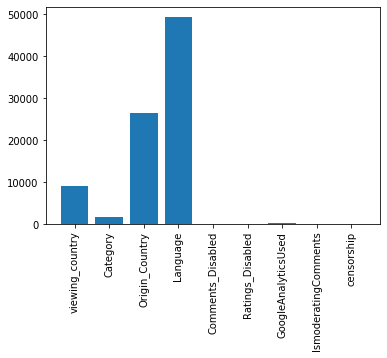

array([9.12627717e+03, 1.76137262e+03, 2.63183784e+04, 4.92911842e+04,
       1.26397132e+02, 9.13939409e+01, 1.33263739e+02, 7.29674712e+01,
       3.34261094e+00])

In [83]:
#Change the way censorship is defined

def censorship_affected(x):
    #function to check the percentage of relative countries blocked for this video
    if (x['Allowed']==x['Allowed']) and (x['viewing_country'] in Country_similarity) and (len(set(Country_similarity[x['viewing_country']]).difference(set(x['Allowed'])))>0):
        return 'YES' 
    elif (x['Blocked']==x['Blocked']) and (x['viewing_country'] in Country_similarity) and (len(set(Country_similarity[x['viewing_country']]).intersection(set(x['Blocked'])))>0):                                                                                             
        return 'YES'
    else:
        return 'NO'
    

#Retrieve Country_Category_Popularity_DF after basic cleanup
Country_Category_Popularity_DF = Basic_Cleanup()
#Derive a new variable censorship if blocking or allowing coutries includes the similar coutries (based on whatching the same videos)
Country_Category_Popularity_DF['censorship'] = Country_Category_Popularity_DF.apply(lambda x: censorship_affected(x),axis=1)
Country_Category_Popularity_DF['Popularity_Category'] = Country_Category_Popularity_DF['Total_Trend_Days'].map(lambda x: map_to_cat(x))      
Country_Category_Popularity_DF.drop(['Blocked', 'Allowed', 'Total_Trend_Days'], inplace=True, axis=1)

feature_selection(Country_Category_Popularity_DF, chi2)
#_=msno.matrix(Country_Category_Popularity_DF)

In [84]:
#Another way to derive censorship (convert censorship to the percentage of block, a numeric value)
def censorship_block_perc(x):
    #function to check the percentage of relative countries blocked for this video
    if (x['Allowed']==x['Allowed']) and (x['viewing_country'] in Country_similarity):
        return 100*len(set(Country_similarity[x['viewing_country']]).difference(set(x['Allowed'])))/len(set(Country_similarity[x['viewing_country']]))  
    elif (x['Blocked']==x['Blocked']) and (x['viewing_country'] in Country_similarity):                                                                                             
        return 100*len(set(Country_similarity[x['viewing_country']]).intersection(set(x['Blocked'])))/len(set(Country_similarity[x['viewing_country']]))
    else:
        return 0.0  
    

# Feature Selection of Numeric Variables  (ANOVA Test)

Feature 0: 405.975540
Feature 1: 5832.627682
Feature 2: 5479.669828
Feature 3: 2522.742284
Feature 4: 3910.207676
Feature 5: 1014.141196
Feature 6: 0.959101


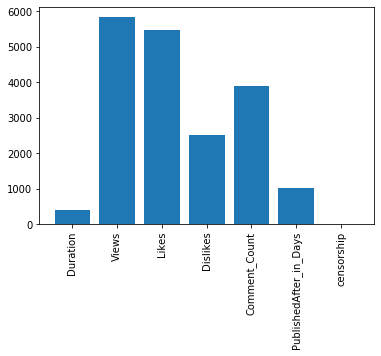

array([4.05975540e+02, 5.83262768e+03, 5.47966983e+03, 2.52274228e+03,
       3.91020768e+03, 1.01414120e+03, 9.59101278e-01])

In [85]:
def Basic_Cleanup_Numeric():
    DF = pd.read_pickle('../Data/Popularity_DF.pkl')

    
    Country_Category_Popularity_DF = DF[['viewing_country', 'Duration', 'Views', 'Likes', 'Dislikes', 'Comment_Count', 'PublishedAfter_in_Days', 'Blocked', 'Allowed', 'Total_Trend_Days']].copy()
    
    #Derive a new variable censorship if blocking or allowing coutries includes the similar coutries (based on whatching the same videos)
    Country_Category_Popularity_DF['censorship'] = Country_Category_Popularity_DF.apply(lambda x: censorship_block_perc(x),axis=1)

    Country_Category_Popularity_DF['Popularity_Category'] = Country_Category_Popularity_DF['Total_Trend_Days'].map(lambda x: map_to_cat(x))      
    Country_Category_Popularity_DF.drop(['viewing_country', 'Blocked', 'Allowed', 'Total_Trend_Days'], inplace=True, axis=1)

    return Country_Category_Popularity_DF


#Retrieve Country_Category_Popularity_DF after basic cleanup
Country_Category_Popularity_DF = Basic_Cleanup_Numeric()

feature_selection(Country_Category_Popularity_DF, f_classif, ravel=True)
#_=msno.matrix(Country_Category_Popularity_DF)

# Study on Categorical Variables

In [102]:
Country_Category_Popularity_DF = DF[['viewing_country', 'Category', 'Origin_Country', 'Language', 'Comments_Disabled', 'Ratings_Disabled', 'Blocked', 'Allowed', 'GoogleAnalyticsUsed', 'IsmoderatingComments', 'Total_Trend_Days']].copy()
Country_Category_Popularity_DF['Popularity_Category'] = Country_Category_Popularity_DF['Total_Trend_Days'].map(lambda x: map_to_cat(x))      

def plot_popularity_distribution(col, text, filename, legend=None, title=None):
    #col:- Column name in Country_Category_Popularity_DF you want to analyse the significance for
    #text:- text in the graph
    #filename:- filename to save
    #legend:- legend names as a list
    
    contingency_table=Country_Category_Popularity_DF.groupby(col)['Popularity_Category'].value_counts().unstack()
    
    stat, p, dof, expected = chi2_contingency(contingency_table)


    # interpret p-value
    alpha = 0.01
    if p <= alpha:
        print(f'Popularity depends on {col} (reject H0)')
    else:
        print(f'Popularity is independent of {col} (fail to reject H0)')
    
    DF=pd.DataFrame(Country_Category_Popularity_DF.groupby(col)['Popularity_Category'].value_counts(normalize=True))
    DF.columns = ['Percentage']
    DF = DF.unstack(level=0)
    DF = DF.loc[['JustTrending', 'Popular', 'UltraPopular', 'Phenomenon'],:]
    DF['Percentage']=DF['Percentage']*100

    DF.columns.name = col
    if legend==None:
        DF.columns = [col[1] for col in DF.columns]
    else:
        DF.columns = legend
        
    yTicks = np.arange(0, (DF.max().max()//10)*10 + 11, 10)
    ax = DF.plot.bar(rot=0, figsize=(8,6))

    #Beautification !!!
    suptitle = (f'Popularity Distribution with and without {col}' if title==None else title)
    _=plt.suptitle(suptitle, fontsize=20, weight='bold', y=1.03)
    _=plt.yticks(yTicks, [f"{val}%" for val in yTicks])

    #xlabel, ylabel
    _=plt.xlabel('Popularity Category',fontsize = 15)
    _=plt.ylabel('Percentage',fontsize = 15)

    #legend
    _=plt.legend(loc='upper right', fontsize = 15)

    bbox_props = dict(boxstyle="round", fc="cyan", ec="b", lw=2, alpha=0.3)
    t = ax.text(0.6, 0.6, text, ha="center", va="center",
            size=15, transform=ax.transAxes,
            bbox=bbox_props)

    _ =plt.tight_layout()
    ax.get_figure().savefig(f'../Image/{filename}',bbox_inches = "tight" )

## Censorship

Popularity depends on censorship (reject H0)


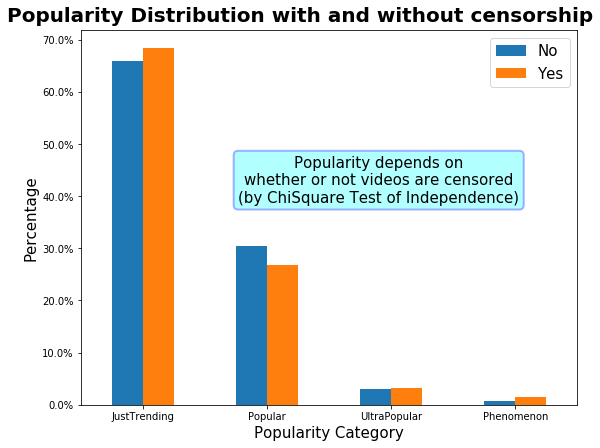

In [105]:
Country_Category_Popularity_DF['censorship'] = Country_Category_Popularity_DF.apply(lambda x: (False if ((x['Blocked']!=x['Blocked']) and (x['Allowed']!=x['Allowed'])) else True),axis=1)
plot_popularity_distribution('censorship', "Popularity depends on\nwhether or not videos are censored\n(by ChiSquare Test of Independence)", 'Effect_of_Censorship_on_popularity.png', legend=["No", "Yes"])


# Study on Comment Moderation

Popularity depends on IsmoderatingComments (reject H0)


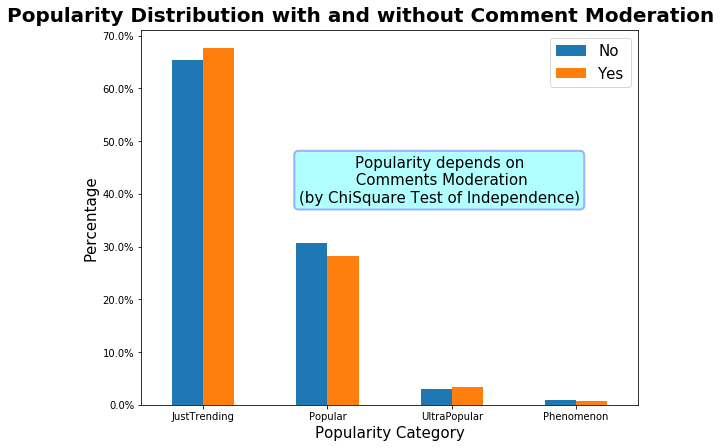

In [106]:
plot_popularity_distribution('IsmoderatingComments', "Popularity depends on\n Comments Moderation\n(by ChiSquare Test of Independence)", 'Effect_of_Comment_Moderation_on_popularity.png', legend=["No", "Yes"], title="Popularity Distribution with and without Comment Moderation" )



## Study on Google Analytics

Popularity depends on GoogleAnalyticsUsed (reject H0)


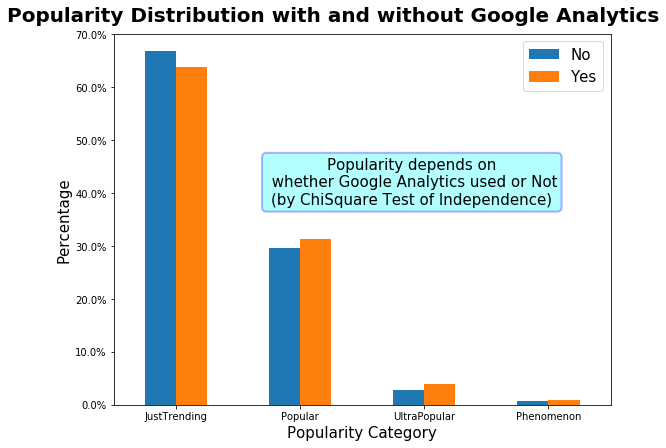

In [109]:
plot_popularity_distribution('GoogleAnalyticsUsed', "Popularity depends on\n whether Google Analytics used or Not\n(by ChiSquare Test of Independence)", 'Effect_of_Google_Analytics_on_popularity.png', legend=["No", "Yes"], title="Popularity Distribution with and without Google Analytics" )


# Duration Vs Longevity

In [112]:
DF = pd.read_pickle("../Data/Popularity_DF.pkl")

In [113]:
DF['Language'].fillna('Unknown', inplace=True)
DF['Language'].replace({'English (United Kingdom)':'English', 'Spanish (Latin America)':'Spanish', 'Spanish (Spain)':'Spanish'}, inplace=True)
DF['Duration'] = DF['Duration']/60

In [114]:
Duration_Popularity_DF = DF[['Total_Trend_Days', 'Duration', 'viewing_country', 'Category', 'Language']]

In [116]:
Duration_Popularity_DF.shape
Duration_Popularity_DF[Duration_Popularity_DF['Duration']>130].shape
proportion = 100*Duration_Popularity_DF[Duration_Popularity_DF['Duration']>130].shape[0]/Duration_Popularity_DF.shape[0]
proportion

(142846, 5)

(3545, 5)

2.4816935720986235

## A scatter plot between Duration and Total_Trend_Days (without removing Live)

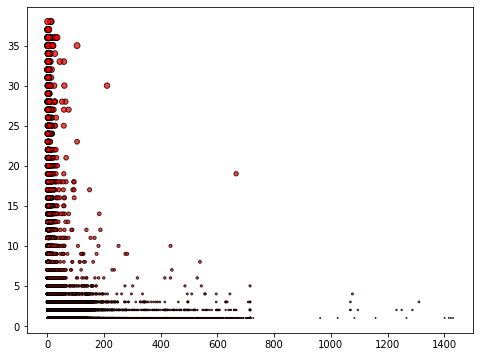

In [117]:
fig, axes = plt.subplots(figsize=(8,6))
_=axes.scatter(Duration_Popularity_DF['Duration'], Duration_Popularity_DF['Total_Trend_Days'], marker="o", facecolors="red", edgecolors="black",
            s=Duration_Popularity_DF['Total_Trend_Days'], alpha=0.75)


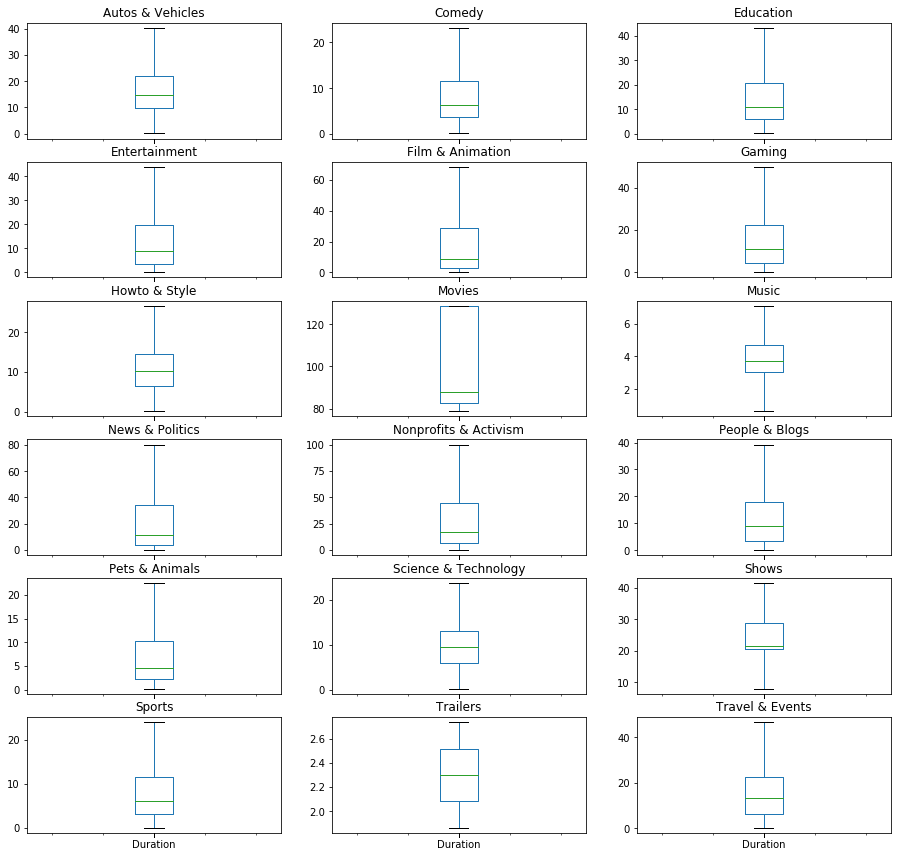

In [118]:
axes = Duration_Popularity_DF.groupby('Category').boxplot(column='Duration', grid=False, subplots=True, figsize=(15,15), layout=(6,3), sharex=True, sharey=False, showfliers=False)


In [119]:
axes[0].get_figure().savefig('../Image/Difference_in_duration_for_various_categories.png')

In [120]:
#There are some live videos that runs for a day. We eliminate all the videos that run for more than 130 minutes (Duration_Popularity_DF[Duration_Popularity_DF['Category']=='Movies'].max())
#Total 3545 videos
Duration_Popularity_DF = Duration_Popularity_DF[Duration_Popularity_DF['Duration']<=130]

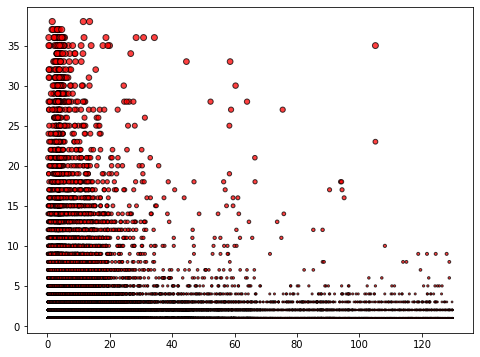

In [121]:
fig, axes = plt.subplots(figsize=(8,6))
_=axes.scatter(Duration_Popularity_DF['Duration'], Duration_Popularity_DF['Total_Trend_Days'], marker="o", facecolors="red", edgecolors="black",
            s=Duration_Popularity_DF['Total_Trend_Days'], alpha=0.75)
